# Quiz

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg as sp_la

# Covariance

As we know from the discussion on Wednesday, independent variables can be correlated not only with the dependent variable but also *with each other*. The degree of correlation tells us how much and in which direction they vary. Formally, the correlation of two variables $x$ and $y$ is $\frac{(x-\mu_x)(y-\mu_y)}{\sigma_x\sigma_y}$.

We can also talk about a related concept, *covariance*. The covariance of two variables $x$ and $y$ is $(x-\mu_x)(y-\mu_y)$.
* The covariance of a $x$ with itself is just the variance of $x$. This is in contrast to the correlation of $x$ with itself, which is always 1.

The *covariance matrix* of a data set tells us about the first order covariance relationships between all pairs of variables. The covariance matrix has the variance of each variable along its diagonal, and the remaining entries are the *covariances* of pairs of variables, ie how much they vary together. If they vary together, then they are related to each other - some information is shared between them.

Questions:
* If the covariance is close to 0, then what is true of the pair of features?
* If the covariance is big, then what is true of the pair of features?
* Correlations can be positive or negative; what about covariances?

We can calculate covariance using matrix multiplication:
* First, center the data: $A_c = A - \mu_A$
* Then, calculate $C$: $C = \frac{1}{N-1} A_c^TA_c$

Let's look at some toy examples (h/t Stephanie Taylor!)

## Example 1

These two variables co-vary.

In [3]:
A = np.array([[1,2,3,0], [1.1, 2.1, 3, 0.5]]).T
A

array([[1. , 1.1],
       [2. , 2.1],
       [3. , 3. ],
       [0. , 0.5]])

In [4]:
# First, center the data
def centerData(data):
    return data - data.mean(axis=0)

# Then, calculate C
def covarMatrix(data):
    centered = centerData(data)
    return (centered.T@centered) / (len(centered)-1) # or centered.shape[0] - 1

print(covarMatrix(A))

[[1.66666667 1.41666667]
 [1.41666667 1.21583333]]


*What do we observe about the variance of X? of Y? What about the covariance?*

## Example 2

This is just like before by the values of $Y$ are now negative.

In [5]:
A = np.array([[1,2,3,0], [-1.1, -2.1, -3, -0.5]]).T
A

array([[ 1. , -1.1],
       [ 2. , -2.1],
       [ 3. , -3. ],
       [ 0. , -0.5]])

In [6]:
# Center the data and calculate C
print(covarMatrix(A))

[[ 1.66666667 -1.41666667]
 [-1.41666667  1.21583333]]


*What do we observe about the variance of X? of Y? What about the covariance?*

## Example 3

The values of $X$ and $Y$ are now random.

In [7]:
A = np.array([np.random.standard_normal(4), np.random.standard_normal(4)]).T
A

array([[-0.23282113,  0.30332525],
       [ 1.47219079,  0.47954931],
       [-2.41569627, -1.34608669],
       [-0.77710933,  0.11077244]])

In [8]:
# Center the data and calculate C
print(covarMatrix(A))

[[2.56902026 1.19335628]
 [1.19335628 0.69833941]]


*What do we observe about the variance of X? of Y? What about the covariance?*

## On our data

### Load the data

Same code as Wednesday!

In [9]:
# these will be our columns
columns = ["price", "year", "manufacturer", "model", "condition", "fuel", "odometer", "title_status", "transmission"]
# this will contain our converters
colValues = {}

# first we load our data as strings so we can define the converters
data = np.array(np.genfromtxt('data/vehicles.csv', delimiter=',', usecols=(1,2,3,4,5,7,8,9,11), skip_header=1, dtype=str, encoding='utf-8'))  

# make a list of the unique values in each column of our data
for colIndex in range(data.shape[1]):
    colValues[colIndex] = np.unique(data[:, colIndex]).tolist()

# fix up some of these ones we know are ordered
colValues[columns.index('condition')] = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage']
colValues[columns.index('title_status')] = ['clean', 'lien', 'rebuilt', 'salvage', 'parts only', 'missing']

# map values to their indices in the list of unique values
def converter(x, colIndex):
    return colValues[colIndex].index(x)

data = np.array(np.genfromtxt('data/vehicles.csv', delimiter=',', usecols=(1,2,3,4,5,7,8,9,11), converters={3: lambda x: converter(x, 2), 4: lambda x: converter(x, 3), 5: lambda x: converter(x, 4), 7: lambda x: converter(x,5), 9: lambda x: converter(x, 7), 11: lambda x: converter(x, 8)}, skip_header=1, dtype=int, encoding='utf-8'))  

### Covariance matrix: raw data

Center the data and calculate C.

In [10]:
# Center the data and calculate C
C = covarMatrix(data)

# I want to see it better!
print(pd.DataFrame(C))

              0              1            2              3             4  \
0  3.073355e+07   12427.290941    49.662629   66503.533053   -968.026677   
1  1.242729e+04      15.981452     0.296067      -6.115148     -0.960249   
2  4.966263e+01       0.296067     0.247112       9.303841     -0.035717   
3  6.650353e+04      -6.115148     9.303841    9249.817841      0.309932   
4 -9.680267e+02      -0.960249    -0.035717       0.309932      0.520323   
5  2.490878e+01       0.028859    -0.001069      -0.367051     -0.001921   
6 -1.796026e+08 -191860.673011 -3775.923497 -823062.498000  23604.907696   
7  1.567459e+01       0.161814     0.002689      -0.593167      0.007900   
8 -3.472057e+02      -0.019850     0.002552     -10.410080      0.003011   

            5             6            7           8  
0   24.908781 -1.796026e+08    15.674592 -347.205734  
1    0.028859 -1.918607e+05     0.161814   -0.019850  
2   -0.001069 -3.775923e+03     0.002689    0.002552  
3   -0.367051 -8.23

Well, that table is hard to look at. Let's plot the covariance matrix.

In an ideal world, your covariance matrix will have a lot of different colors in it. That's a dataset you can use!

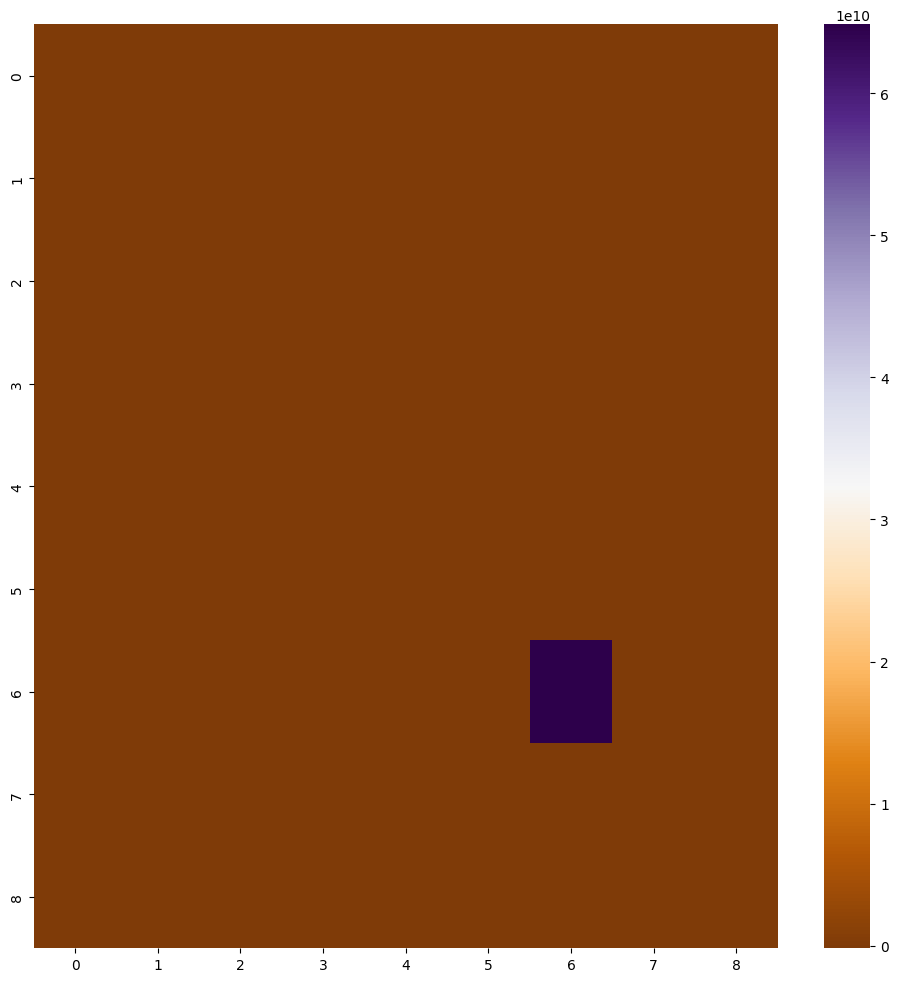

In [11]:
fig = plt.figure(figsize=(12,12))
sns.heatmap(pd.DataFrame(C), annot=False, cmap='PuOr')
plt.show()

*What do we observe?*

### Covariance matrix: min-max global

Now let's try:
1. min-max global our data
2. center and covariance matrix

In [12]:
homogenizedData = np.append(data, np.array([np.ones(data.shape[0], dtype=int)]).T, axis=1)

# subtract the global minimum from each datapoint
translateTransform = np.eye(homogenizedData.shape[1], dtype=float)
for i in range(data.shape[1]):
    translateTransform[i, -1] = -data.min()

# divide by the global range
scaleTransform = np.eye(homogenizedData.shape[1])
for i in range(data.shape[1]):
    scaleTransform[i, i] = 1/(data.max()-data.min())

totalTransform = scaleTransform@translateTransform
transformedData = (totalTransform@homogenizedData.T).T


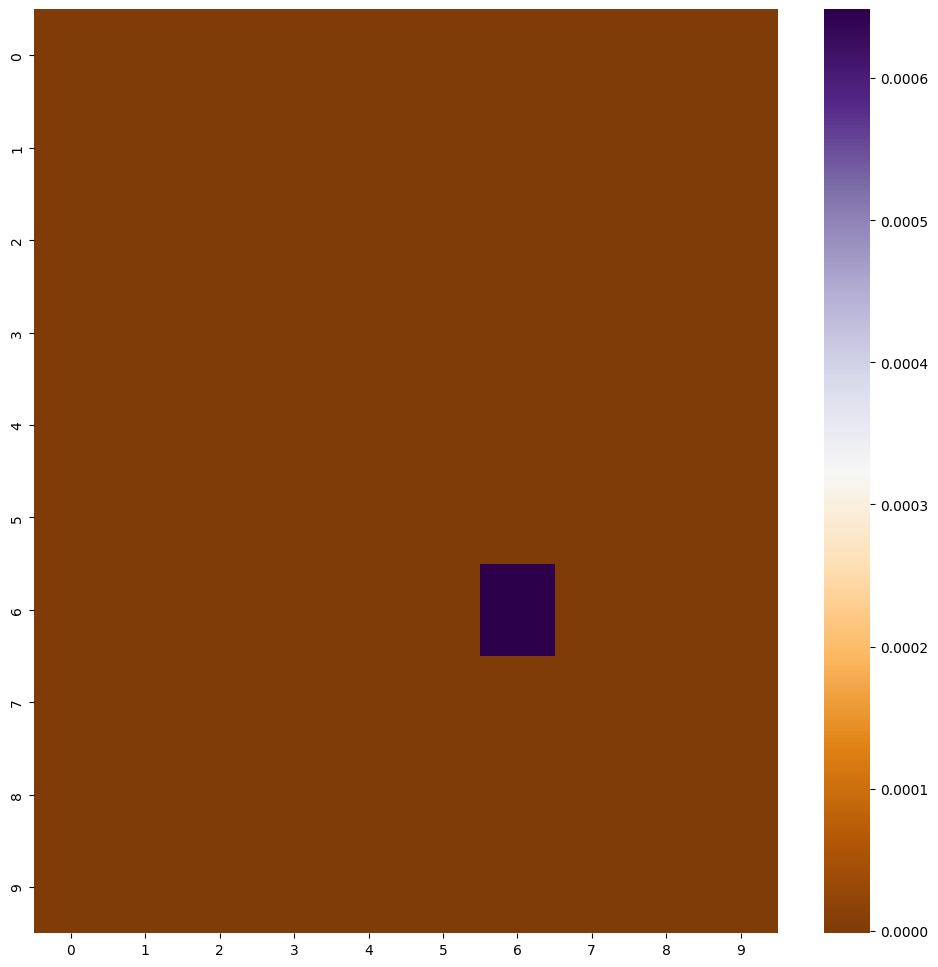

In [13]:
# Center the data and calculate C
C = covarMatrix(transformedData)

# Let's look at the covariance matrix
fig = plt.figure(figsize=(12,12))
sns.heatmap(pd.DataFrame(C), annot=False, cmap='PuOr')
plt.show()

*What do we observe?*

### Covariance matrix: min-max local

Now let's try:
1. min-max local our data
2. center and covariance matrix

In [14]:
translateTransform = np.eye(homogenizedData.shape[1], dtype=float)
for i in range(data.shape[1]):
    translateTransform[i, -1] = -data[:, i].min()

scaleTransform = np.eye(homogenizedData.shape[1], dtype=float)
for i in range(data.shape[1]):
    scaleTransform[i, i] = 1/(data[:, i].max()-data[:, i].min())

totalTransform = scaleTransform@translateTransform

transformedData = (totalTransform @ homogenizedData.T).T

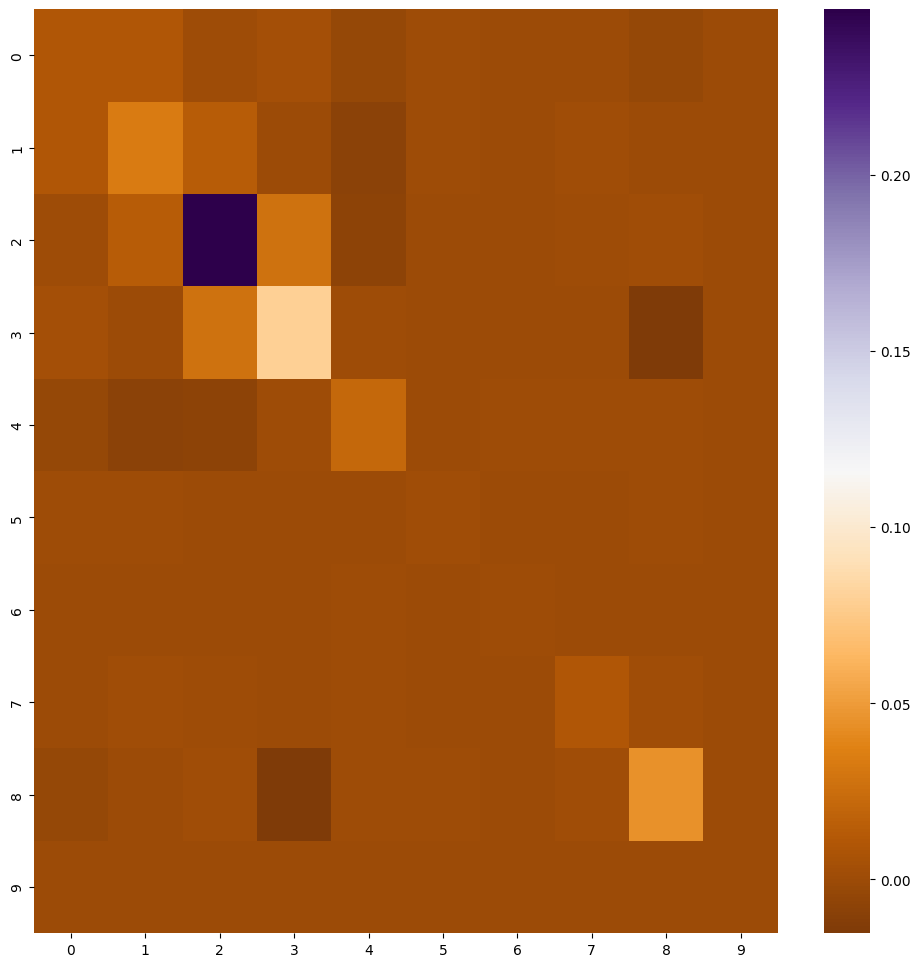

In [15]:
# Center the data and calculate C
C = covarMatrix(transformedData)

# Let's look at the covariance matrix
fig = plt.figure(figsize=(12,12))
sns.heatmap(pd.DataFrame(C), annot=False, cmap='PuOr')
plt.show()

*What do we observe?*

### Covariance matrix: z-score

Now let's try:
1. z-score our data (subtract the mean and divide by the standard deviation; this also centers the data)
2. (center and) covariance matrix

In [16]:
translateTransform = np.eye(homogenizedData.shape[1], dtype=float)
for i in range(data.shape[1]):
    translateTransform[i, -1] = -data[:, i].mean()

scaleTransform = np.eye(homogenizedData.shape[1], dtype=float)
for i in range(data.shape[1]):
    scaleTransform[i, i] = 1/data[:, i].std()

totalTransform = scaleTransform@translateTransform

transformedData = (totalTransform @ homogenizedData.T).T

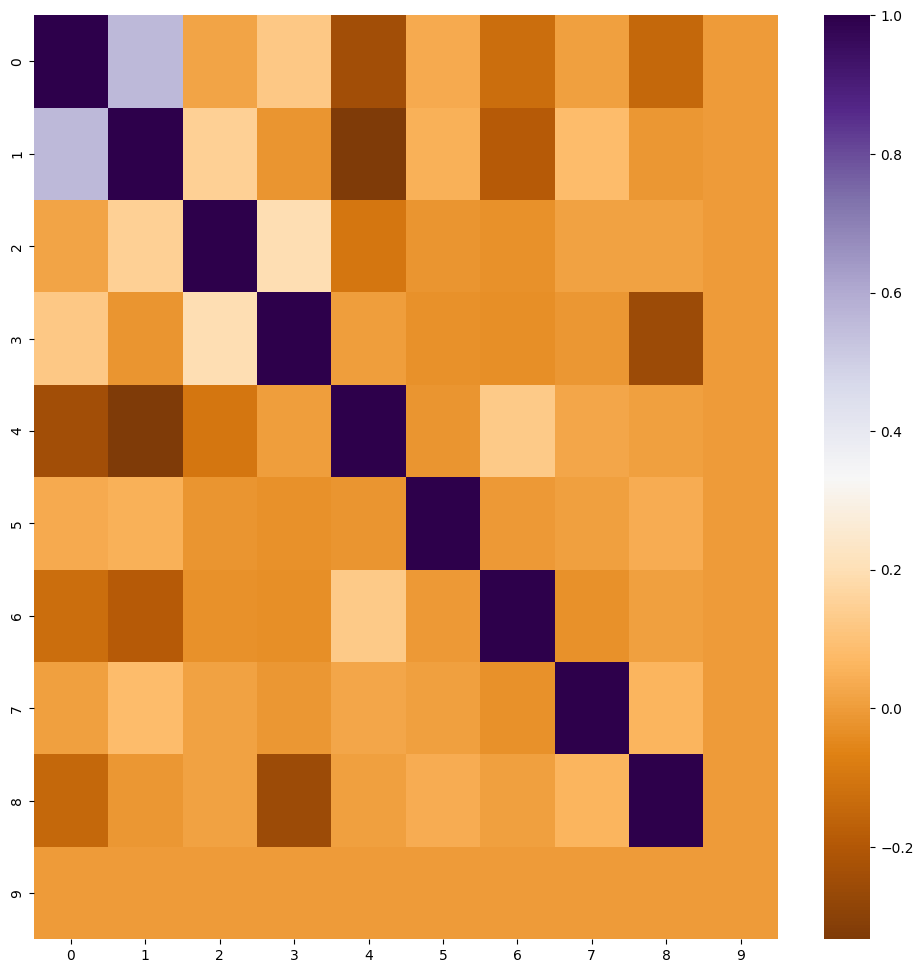

In [17]:
# Center the data and calculate C
C = covarMatrix(transformedData)

# Let's look at the covariance matrix
fig = plt.figure(figsize=(12,12))
sns.heatmap(pd.DataFrame(C), annot=False, cmap='PuOr')
plt.show()

*What do we observe?*

## Warning

This is a thing that will calculate the covariance matrix for you, but you *may not use it* for your project: np.cov

# The curse of dimensionality

When data is very multidimensional, everything becomes slower and more complicated:
* How can you look at your data? There's too much there!
* How can you normalize your data? Without being able to look at it, what normalizations would you know to apply?
* How can you fit a regression to your data? Which variables would you choose?

In fact, data in a high dimensional space just is different:
* there are more extreme values. In a 2 dimensional unit square, the probability that a random point is within 0.001 of the border is 0.004, but in a 10000 dimensional unit hypercube, the probability is > 0.999.
* the distances between points are bigger. In a 2 dimensional unit square, the average distance between two points is about 0.5. In a 3 dimensional unit cube, it's 0.66. But in a 10000 dimensional unit hypercube, it's about 408.25.

Here's the thing though: generally, only a small fraction of variables in a data set suffice to model the whole. For example, very often many features do covary. So we can use covariance information to *project* our data to a much smaller dimensional space and analyze the data in that space instead. The technique we will use for that is *principal component analysis* (PCA).